In [40]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import make_pipeline
from pylab import rcParams
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing

import data_preprocessing
%matplotlib inline
params = {'axes.labelsize': 14,'axes.titlesize':14, 'text.fontsize': 14, 'legend.fontsize': 14,
          'xtick.labelsize': 13, 'ytick.labelsize': 14}
rcParams['figure.figsize'] = 6.5, 4

matplotlib.rcParams.update(params)

/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:913: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [41]:
import imp
data_preprocessing = imp.reload(data_preprocessing)

In [42]:
output_path = "./Plots/"


In [6]:
data_original = pd.read_csv('./Data Mining VU data/training_set_VU_DM_2014.csv')

In [81]:
n_select = 4200000
df = data_original.tail(n_select)
df_original = data_original.tail(n_select)
data = data_original.tail(n_select)

#  Feature Engineering

## Composite features
Rank by group
1. Extract season: autumn, summer, winter 


In [82]:
df['date_time']= pd.to_datetime(df['date_time'])
df = df.drop(['date_time'], axis=1)


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [83]:
all_cols = df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])


### NEW FEATURES

In [84]:
df['price_diff_from_historic_mean']= df.price_usd - df.visitor_hist_adr_usd
df['star_diff_from_historic_mean']= df.prop_starrating - df.visitor_hist_starrating

### Outliers
For features with high value outliers cap to maximum

In [85]:
df_before = df.copy()
df = data_preprocessing.remove_outliers(df)
create_plots=None

/Users/efiathieniti/PycharmProjects/DM2018/Assignment2/data_preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feature][df[feature]>df[feature].quantile(0.99)] = df[feature].quantile(0.99)
/Users/efiathieniti/PycharmProjects/DM2018/Assignment2/data_preprocessing.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feature][df[feature]<df[feature].quantile(0.01)] = df[feature].quantile(0.01)


In [55]:

if create_plots:
    
    for feature in all_cols:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2)  
        df_before[[feature]].hist(bins=10, ax=ax2)
        df[[feature]].hist(bins=10, ax=ax1)
        plt.savefig(output_path + "hist_remove_outliers_%s.png"%feature, format='png')

        plt.show()



In [86]:
# about 15 mins for the full dataset.. 

df = data_preprocessing.create_composite_features(df)
# Remove outliers before normalizing?
df = data_preprocessing.normalize_within_group(df)
df['log_price_usd'].quantile(0.99)  

/Users/efiathieniti/PycharmProjects/DM2018/Assignment2/data_preprocessing.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feature][df[feature].isnull()] = df[feature].median()
/Users/efiathieniti/PycharmProjects/DM2018/Assignment2/data_preprocessing.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[feature][df[feature].isnull()] = df[feature].median()


2.7746045457003254

### Set Missing values to median
Do this after new features are created?

In [87]:
all_cols=df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])

for feature in all_cols:
    df[feature][df[feature].isnull()] = df[feature].median()


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [88]:
# Subselect columns - include booking_book
summary_metrics = pd.DataFrame(df.describe())

In [89]:
df=df[list(summary_metrics.columns)]

In [90]:
summary_metrics

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,star_rank,value_for_money,prop_location_score1_norm,prop_location_score2_norm,prop_location_score_mean,comp1_rate_percent_diff_log,log_price_usd,price_usd_norm_srch_id,value_for_money_norm_srch_id,price_usd_norm_prop_id
count,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,...,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06,4.200000e+06
mean,1.918246e+05,9.971451e+00,1.752552e+02,3.436554e+00,1.529698e+02,1.739487e+02,7.007922e+04,3.179148e+00,3.776816e+00,6.342805e-01,...,9.935938e+01,1.802195e+00,8.677156e-12,-9.269673e-12,-2.979760e-13,1.002815e+00,2.103737e+00,-8.820463e-04,2.794345e-04,4.669295e-17
std,8.137236e+04,7.618913e+00,6.583013e+01,1.563774e-01,2.191880e+01,6.817240e+01,4.058665e+04,1.051632e+00,1.050851e+00,4.816314e-01,...,7.335612e+02,4.975636e-01,1.000000e+00,1.000000e+00,8.415236e-01,8.666784e-02,2.521118e-01,9.795557e-01,9.792858e-01,1.414769e-01
min,5.353500e+04,5.000000e+00,1.500000e+01,2.000000e+00,4.450000e+01,1.400000e+01,1.399000e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,1.000000e+00,0.000000e+00,-1.881483e+00,-8.281784e-01,-1.354831e+00,3.010300e-01,1.531479e+00,-5.480078e+00,-5.386868e+00,-3.094445e+00
25%,1.214850e+05,5.000000e+00,1.000000e+02,3.440000e+00,1.518400e+02,1.000000e+02,3.501000e+04,3.000000e+00,3.500000e+00,0.000000e+00,...,6.000000e+00,1.687146e+00,-7.076367e-01,-6.245030e-01,-5.907386e-01,1.000000e+00,1.929419e+00,-6.960637e-01,-4.379071e-01,0.000000e+00
50%,1.919990e+05,5.000000e+00,2.190000e+02,3.440000e+00,1.518400e+02,2.190000e+02,6.962700e+04,3.000000e+00,4.000000e+00,1.000000e+00,...,1.100000e+01,1.886282e+00,-6.497213e-02,-3.372135e-01,-1.579881e-01,1.000000e+00,2.086360e+00,-1.868828e-01,1.808359e-01,0.000000e+00
75%,2.623400e+05,1.400000e+01,2.190000e+02,3.440000e+00,1.518400e+02,2.190000e+02,1.051710e+05,4.000000e+00,4.500000e+00,1.000000e+00,...,1.800000e+01,2.070692e+00,7.678687e-01,1.508928e-01,4.431299e-01,1.000000e+00,2.265737e+00,5.368438e-01,6.145210e-01,0.000000e+00
max,3.299870e+05,3.200000e+01,2.200000e+02,5.000000e+00,5.674600e+02,2.200000e+02,1.393760e+05,5.000000e+00,5.000000e+00,1.000000e+00,...,1.039500e+04,3.264818e+00,2.236816e+00,4.300868e+00,3.268842e+00,3.815378e+00,2.774605e+00,5.570485e+00,4.740206e+00,1.849360e+00


### Calculate correlation and mutual information/information gain

### Histograms

## Distribution of each feature for booked and not booked hotels
Helps find the most discriminative features

In [91]:
# Create the relevance class
all_cols=df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])
df["relevance"] = df["booking_bool"]+ df["click_bool"]
df['relevance'] = df['relevance'].map({0:0, 1:1, 2:5})
class_to_plot = "relevance"

In [ ]:
if create_plots:
    for feature in all_cols:
        try:
            fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))  
            df.groupby(class_to_plot)[feature].plot(kind='kde', ax=ax1, label=class_to_plot)

            plt.title(feature)

            data.groupby(class_to_plot)[feature].plot(kind='kde', ax=ax2)
            plt.savefig(output_path + "densityplot_before_after_%s.png"%feature, format='png')
            plt.show()
        except:
            pass


In [64]:
all_cols=df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position', 'relevance'])


# Correlation with booking

In [ ]:
df['prop_starrating_monot']=abs(df.prop_starrating - df.prop_starrating.mean())

def categorical_plot(df, feature, class_to_plot):
    cat_feat = 'cat'
    df_temp=df
    df_temp[cat_feat]=pd.cut(df[feature], right=False, bins=5)
    sp = sns.pointplot(x=cat_feat, y=class_to_plot, data=df_temp)
    plt.xlabel(feature)
    plt.xticks(rotation=70)
    plt.show()
    


#sns.swarmplot(x='prop_starrating', y="booking_bool", data=df)


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


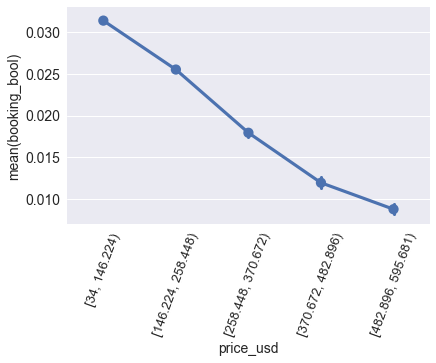

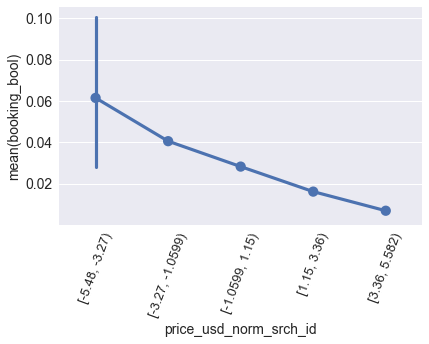

/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:

# New feature creation
# TODO: move to data_preprocessing file 
# Here to compare before and after
group='srch_id'

feature = "log_price_usd"
feature = "price_usd"
df_original[feature] = df[feature]
df['price_usd_norm_srch_id'] = data_preprocessing.normalize(df_original, feature, group)

class_to_plot = "relevance"
class_to_plot = "booking_bool"
categorical_plot(df,feature , class_to_plot)
feature = "price_usd_norm_srch_id"
categorical_plot(df,feature,class_to_plot )

feature = "value_for_money"
#categorical_plot(df,feature,class_to_plot )
#feature = "value_for_money_norm_srch_id"
#categorical_plot(df,feature,class_to_plot )

feature = "log_price_usd"
df_original[feature] = df[feature]
df['price_usd_log_norm_srch_id'] = data_preprocessing.normalize(df_original, feature, group)

class_to_plot = "relevance"
class_to_plot = "booking_bool"
categorical_plot(df,feature , class_to_plot)
feature = "price_usd_log_norm_srch_id"
categorical_plot(df,feature,class_to_plot )

feature = "value_for_money"
#categorical_plot(df,feature,class_to_plot )
#feature = "value_for_money_norm_srch_id"
#categorical_plot(df,feature,class_to_plot )


In [ ]:
feature = "prop_starrating"
categorical_plot(df,feature,class_to_plot)

In [ ]:
feature = "srch_booking_window"
class_to_plot = "relevance"
feature = "prop_location_score1"
categorical_plot(df,feature,class_to_plot)
feature = "prop_location_score2"
categorical_plot(df,feature,class_to_plot)
feature = "prop_location_score_mean"
categorical_plot(df,feature,class_to_plot)

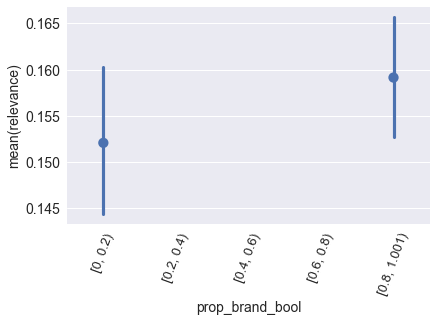

In [72]:
# Can we improve this one?
feature = "prop_brand_bool"
categorical_plot(df,feature,class_to_plot)

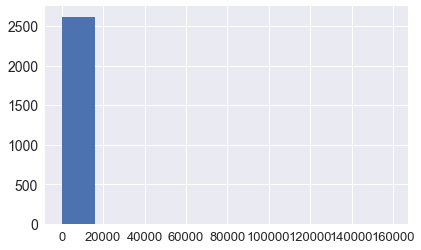

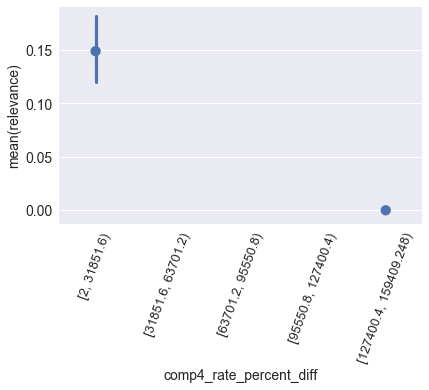

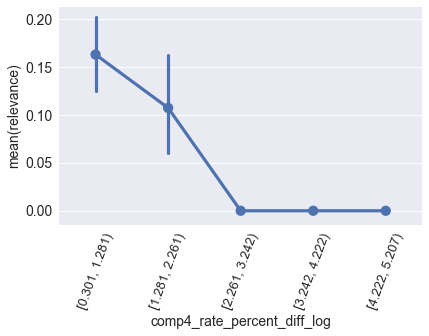

In [73]:
feature = "comp4_rate_percent_diff"
df[feature+"_log"]=np.log10(df_original[feature])
df[feature] = df_original[feature]
df[feature].hist()
plt.show()
categorical_plot(df,feature,class_to_plot)
feature =feature+"_log"
categorical_plot(df,feature,class_to_plot)

In [ ]:

for feature in all_cols:
    df[feature][df[feature].isnull()] = df[feature].median()


In [ ]:
create_plots=False
comp_feats=['comp1_rate','comp2_rate','comp3_rate','comp4_rate','comp5_rate','comp6_rate','comp7_rate','comp8_rate']

for feat in comp_feats:


    df[feat + "_percent_diff_signed"]=np.log10(df_original[feat+"_percent_diff"])*df_original[feat]
    #df[feat + "_percent_diff_signed"] = np.log10(df[feat + "_percent_diff_signed"]).replace([np.inf, -np.inf], np.nan)
    categorical_plot(df,feat + "_percent_diff_signed",class_to_plot)

    feature =  feat + "_percent_diff_signed"
    df[feature+"_norm"]=(df[feature] - df[feature].mean()) / (df[feature].std())

    feature = feat + "_percent_diff_signed_norm"
    if create_plots:
        categorical_plot(df,feature,class_to_plot)
    plt.show()
    



In [ ]:

# Take an average of the comp1_rate_percent_diff after normalizing
comp_feats=['comp1_rate','comp2_rate','comp3_rate','comp4_rate','comp5_rate','comp6_rate','comp7_rate','comp8_rate']
comp_feats_signed=[]
for feat in comp_feats:
    comp_feats_signed.append(feat+'_percent_diff_signed')
    
df['comp_rate_percent_diff_mean']=df[comp_feats_signed].mean(axis=1)
df['comp_rate_percent_diff_mean'].hist()
plt.show()
categorical_plot(df,'comp_rate_percent_diff_mean',class_to_plot)



In [ ]:
feat = "comp7_rate"
df[feat + "_percent_diff_log"]=np.log10(df_original[feat+"_percent_diff"])*df_original[feat]
df[feat + "_percent_diff_log"] = df[feat + "_percent_diff_log"].replace([np.inf, -np.inf], np.nan)
categorical_plot(df,feat + "_percent_diff_log",class_to_plot)

### Comments and Findings

Position bias 

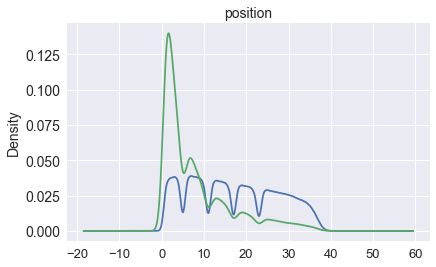

In [119]:

discriminative_features = ['position']

feature = discriminative_features[0]
df.groupby("booking_bool")[feature].plot(kind='kde')
plt.title(feature)
plt.show()

## Mutual information with booking 
Gives the most important features based on univariate statistics

In [ ]:
try:
    df = df.drop(['cat'], axis=1)
except:
    pass


In [ ]:
all_cols = df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position'])
for feature in all_cols:

    df[feature] = df[feature].replace([np.inf, -np.inf], np.nan)
    df[feature][df[feature].isnull()] = df[feature].median()


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-c

In [ ]:
# correlated features, they were used to create new ones therefore drop to reduce 
# mutual info calculation 
TO_DROP=[
 'comp1_rate','comp2_rate','comp3_rate','comp4_rate','comp5_rate',
 'comp6_rate','comp7_rate','comp8_rate',
 'comp6_rate_percent_diff',
 'comp4_rate_percent_diff',
 'comp7_rate_percent_diff',
 'comp1_rate_percent_diff',
 'comp3_rate_percent_diff',
 'comp2_rate_percent_diff',
 'comp8_rate_percent_diff',
 'comp5_rate_percent_diff',
 'comp1_rate_percent_diff_signed_norm',
 'comp2_rate_percent_diff_signed_norm',
 'comp4_rate_percent_diff_signed_norm',
 'comp8_rate_percent_diff_signed_norm',
 'comp3_rate_percent_diff_signed_norm',
 'comp5_rate_percent_diff_signed_norm',
 'comp6_rate_percent_diff_signed_norm',
 'comp7_rate_percent_diff_signed_norm']

In [ ]:
df = df.drop(TO_DROP, axis=1)


In [ ]:
all_cols=df.columns.drop(['booking_bool', 'click_bool', 'gross_bookings_usd', 'position', 'relevance'])
all_cols

In [269]:
# why does relevance have nans?


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [ ]:
from sklearn.feature_selection import mutual_info_classif

df_subset = df

run_mutual_information = None
#mutual_information_click = mutual_info_classif(df[all_cols], df[['click_bool']], discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
#click_df = pd.DataFrame(mutual_information_click.flatten(), columns = ['mutual_info'])
#click_df['feature'] = df[all_cols].columns.values

if run_mutual_information:
    #all_cols = comp_feats_signed+['comp_rate_percent_diff_mean']
    mutual_information_relevance = mutual_info_classif(df_subset[all_cols], df_subset[['relevance']], discrete_features='auto', n_neighbors=3, copy=True, random_state=None)
    relevance_df = pd.DataFrame(mutual_information_relevance.flatten(), columns = ['mutual_info'])
    relevance_df['feature'] = df_subset[all_cols].columns.values



In [ ]:
# ind = np.arange(len(mutual_information_book))
# fig, ax = plt.subplots(figsize=(20,7)) 

# plt.bar(ind, click_df.sort('mutual_info', ascending=False)['mutual_info'])
# plt.xticks(ind,click_df.sort('mutual_info', ascending=False)['feature'], rotation=80)
# plt.title('Mutual Information with Relevance Bool')
# plt.savefig(output_path + "MutualInformation_click_bool.png", format='png')
# plt.show()


# ind = np.arange(len(mutual_information_click))
# fig, ax = plt.subplots(figsize=(20,7)) 

# plt.bar(ind, book_df.sort('mutual_info', ascending=False)['mutual_info'])
# plt.xticks(ind,book_df.sort('mutual_info', ascending=False)['feature'], rotation=80)
# plt.title('Mutual Information with Booking Bool')
# plt.savefig(output_path + "MutualInformation_book_bool.png", format='png')
# plt.show()

if run_mutual_information:
    ind = np.arange(len(mutual_information_relevance))
    fig, ax = plt.subplots(figsize=(20,10)) 

    plt.bar(ind, relevance_df.sort('mutual_info', ascending=False)['mutual_info'])
    plt.xticks(ind,relevance_df.sort('mutual_info', ascending=False)['feature'], rotation=80)
    plt.title('Mutual Information with Relevance')
    plt.tight_layout()
    plt.savefig(output_path + "MutualInformation_relevance_%s.png"%(df.shape[1]), format='png')
    plt.show()



In [ ]:
best= relevance_df.sort('mutual_info', ascending=False)['feature'][:55].values
list(best )

In [ ]:
df.to_pickle('cleaned_dataset')


### Only save selected features to allow upload to github 
not needed if running local

In [210]:

df_2 = df.head(4200000)

#Select the same features from each dataset
selected_features = ['comp6_rate_percent_diff_signed',
 'comp4_rate_percent_diff_signed',
 'comp8_rate_percent_diff_signed',
 'comp7_rate_percent_diff_signed',
 'star_diff_from_historic_mean',
 'visitor_hist_adr_usd',
 'srch_query_affinity_score',
 'srch_room_count',
 'visitor_hist_starrating',
 'price_diff_from_historic_mean',
 'srch_adults_count',
 'prop_brand_bool',
 'prop_country_id',
 'visitor_location_country_id',
 'prop_starrating',
 'prop_review_score',
 'srch_saturday_night_bool',
 'site_id',
 'srch_length_of_stay',
 'prop_starrating_monot',
 'random_bool',
 'promotion_flag',
 'prop_location_score_mean',
 'orig_destination_distance',
 'srch_children_count',
 'prop_location_score2',
 'prop_id',
 'star_rank']

selected_features = list(set(selected_features))
features_to_keep = ['booking_bool', 'srch_id', 'click_bool', 'prop_id', 'relevance']
all_possible_features = features_to_keep + selected_features
df_2 = df_2.ix[:,all_possible_features]



In [215]:
df_cut = df.head(4200000)
df_cut.to_pickle('cleaned_dataset')


In [216]:
list(relevance_df.sort('mutual_info', ascending=False)['feature'][1:50])


/Users/efiathieniti/miniconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  """Entry point for launching an IPython kernel.


['comp4_rate_percent_diff_signed',
 'comp8_rate_percent_diff_signed',
 'comp7_rate_percent_diff_signed',
 'comp7_rate_percent_diff_log',
 'comp3_rate_percent_diff_signed',
 'comp2_rate_percent_diff_signed',
 'comp5_rate_percent_diff_signed',
 'star_diff_from_historic_mean',
 'visitor_hist_adr_usd',
 'comp1_rate',
 'comp6_rate_percent_diff',
 'comp1_rate_percent_diff_log',
 'comp4_rate_percent_diff',
 'srch_query_affinity_score',
 'comp7_rate_percent_diff',
 'comp1_rate_percent_diff',
 'comp3_rate_percent_diff',
 'srch_room_count',
 'comp2_rate_percent_diff',
 'comp8_rate_percent_diff',
 'visitor_hist_starrating',
 'price_diff_from_historic_mean',
 'comp1_rate_percent_diff_signed',
 'comp5_rate_percent_diff',
 'srch_adults_count',
 'prop_brand_bool',
 'prop_country_id',
 'visitor_location_country_id',
 'comp1_rate_percent_diff_signed_norm',
 'prop_starrating',
 'prop_review_score',
 'srch_saturday_night_bool',
 'site_id',
 'srch_length_of_stay',
 'comp4_rate_percent_diff_signed_norm',
 

In [75]:
features_to_keep = ['booking_bool', 'click_bool', 'srch_id', 'relevance']
selected_features = ['value_for_money','value_for_money_normalized','price_usd', 'price_usd_normalized','price_rank','price_diff_from_historic_mean', 'star_rank', 'prop_review_score', 'position',
                     'prop_brand_bool', 'prop_location_score1']

selected_features = ['comp6_rate_percent_diff_signed', 'comp4_rate_percent_diff_signed',
       'star_diff_from_historic_mean', 'visitor_hist_adr_usd',
       'srch_query_affinity_score',
       'srch_room_count', 'visitor_hist_starrating',
       'price_diff_from_historic_mean', 'srch_adults_count', 'prop_brand_bool',
       'prop_country_id', 'visitor_location_country_id', 'prop_starrating',
       'prop_review_score', 'srch_saturday_night_bool', 'site_id',
       'srch_length_of_stay', 'comp4_rate_percent_diff_signed_norm',
       'comp8_rate_percent_diff_signed_norm', 'prop_starrating_monot',
       'random_bool', 'comp3_rate_percent_diff_signed_norm']

all_possible_features = selected_features+features_to_keep

In [76]:
all_possible_features

['comp6_rate_percent_diff_signed',
 'comp4_rate_percent_diff_signed',
 'star_diff_from_historic_mean',
 'visitor_hist_adr_usd',
 'srch_query_affinity_score',
 'srch_room_count',
 'visitor_hist_starrating',
 'price_diff_from_historic_mean',
 'srch_adults_count',
 'prop_brand_bool',
 'prop_country_id',
 'visitor_location_country_id',
 'prop_starrating',
 'prop_review_score',
 'srch_saturday_night_bool',
 'site_id',
 'srch_length_of_stay',
 'comp4_rate_percent_diff_signed_norm',
 'comp8_rate_percent_diff_signed_norm',
 'prop_starrating_monot',
 'random_bool',
 'comp3_rate_percent_diff_signed_norm',
 'booking_bool',
 'click_bool',
 'srch_id',
 'relevance']

In [82]:
all_possible_features = list(set.intersection(set(all_possible_features), set(df.columns.values)))

In [94]:
correlation =df[all_possible_features+['relevance']].corr()

In [88]:
correlation

<bound method DataFrame.corr of         visitor_hist_adr_usd  visitor_location_country_id  \
0                     154.27                          187   
1                     154.27                          187   
2                     154.27                          187   
3                     154.27                          187   
4                     154.27                          187   
5                     154.27                          187   
6                     154.27                          187   
7                     154.27                          187   
8                     154.27                          187   
9                     154.27                          187   
10                    154.27                          187   
11                    154.27                          187   
12                    154.27                          187   
13                    154.27                          187   
14                    154.27                         

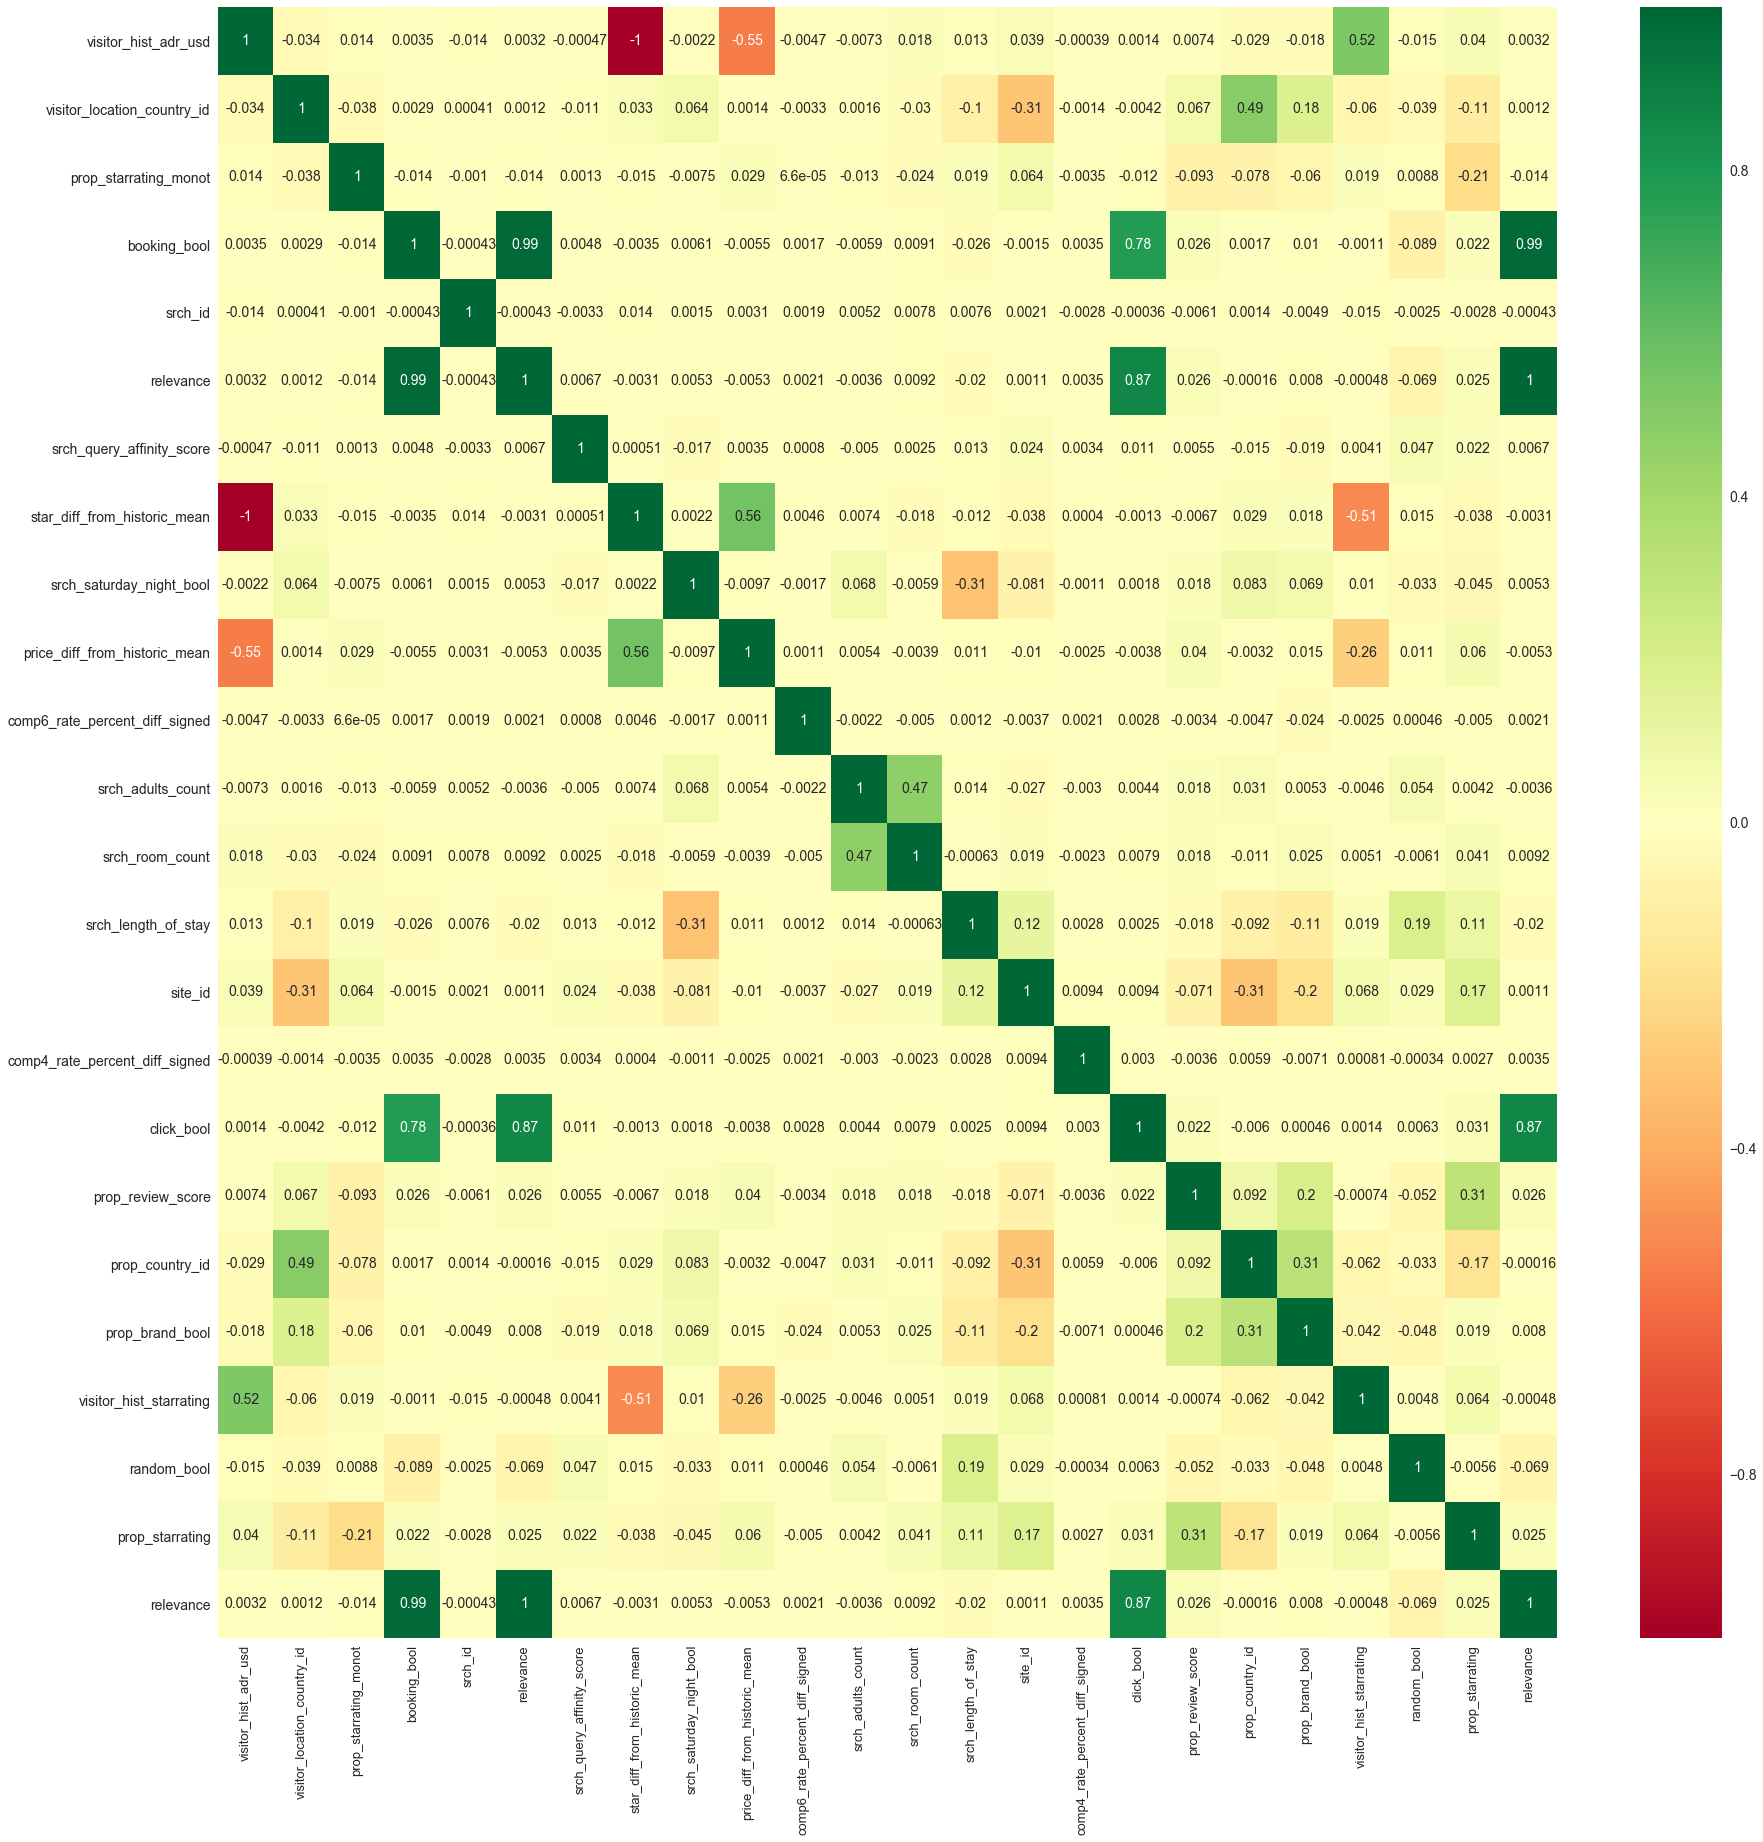

In [95]:

def plot_corr(data, correlation):
    fig, ax = plt.subplots(figsize=(30,30)) 
    sns.heatmap(correlation, annot=True, cbar=True, cmap="RdYlGn")
    plt.savefig(output_path + "correlation_plot.png", format='png')

plot_corr(df[all_possible_features+['relevance']], correlation)





In [167]:
correlation.abs
c = correlation.abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")

so

prop_starrating_monot           comp6_rate_percent_diff_signed    0.000066
comp6_rate_percent_diff_signed  prop_starrating_monot             0.000066
relevance                       prop_country_id                   0.000155
                                prop_country_id                   0.000155
prop_country_id                 relevance                         0.000155
                                relevance                         0.000155
comp4_rate_percent_diff_signed  random_bool                       0.000339
random_bool                     comp4_rate_percent_diff_signed    0.000339
click_bool                      srch_id                           0.000356
srch_id                         click_bool                        0.000356
visitor_hist_adr_usd            comp4_rate_percent_diff_signed    0.000393
comp4_rate_percent_diff_signed  visitor_hist_adr_usd              0.000393
                                star_diff_from_historic_mean      0.000404
star_diff_from_historic_m